In [1]:
import stackstac
import satsearch
from datetime import datetime
import dask.diagnostics

import rioxarray
import xarray as xr
import numpy as np
import geopandas as gpd
import geojson
import json

from datetime import datetime

from shapely.geometry import mapping

import zarr

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\stackstac\lib\site-packages\ipykernel\parentpoller.py:110: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [30]:
import os
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
                   AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))


os.environ.update(env)


In [31]:
bbox = [150.53718391857018, -34.47320307771639, 151.25748275818813,  -33.82982205634835]  #plot below                    
bbox = [-53.0232820986343754,-8.1236837545427090, -49.4688521093868800,-4.8677173521785928]

In [38]:
import os
%env AWS_NO_SIGN_REQUEST=Yes

t0 = datetime.now()
stac_found = satsearch.Search(
    url="https://explorer.dev.digitalearth.africa/stac/",
    bbox=bbox,
    collections=["esri_land_cover"],
    datetime="2000-02-01/2022-03-31",
).found()  
print(stac_found)

stac_items = satsearch.Search(
    url="https://explorer.dev.digitalearth.africa/stac/",
    bbox=bbox,
    collections=["esri_land_cover"],
    datetime="2000-02-01/2021-03-31",
).items()

print('searching time: {}'.format(datetime.now()-t0))

print("Num of Items", len(stac_items))

t0 = datetime.now()
stack = stackstac.stack(stac_items, epsg=6933, resolution=10, resampling=1, dtype='uint8', fill_value=0)

print('lazy stacking time: {}'.format(datetime.now()-t0))

print("Stack Size in GB: ", round(stack.nbytes/1e9,0))

stack


env: AWS_NO_SIGN_REQUEST=Yes
2
searching time: 0:00:05.944842
Num of Items 2
lazy stacking time: 0:00:01.160961
Stack Size in GB:  0.0


,Array,Chunk
Bytes,28.12 GiB,1.00 MiB
Shape,"(2, 1, 217080, 69533)","(1, 1, 1024, 1024)"
Count,43252 Tasks,28832 Chunks
Type,uint8,numpy.ndarray


In [39]:
#filename = r'F:\Brazil\Brazil1.geojson'
filename = r'F:\Brazil\CarraGrav1.geojson'
filename = r'F:\Brazil\CarraGrav2.shp'
brazil = gpd.read_file(filename)

from shapely.geometry import mapping

cropped = stack.rio.clip(brazil.geometry.apply(mapping), crs=4326)
cropped

,Array,Chunk
Bytes,2.63 GiB,1.00 MiB
Shape,"(2, 1, 41196, 34282)","(1, 1, 1024, 1024)"
Count,135489 Tasks,2870 Chunks
Type,uint8,numpy.ndarray


In [40]:
stack[0]

,Array,Chunk
Bytes,14.06 GiB,1.00 MiB
Shape,"(1, 217080, 69533)","(1, 1024, 1024)"
Count,57668 Tasks,14416 Chunks
Type,uint8,numpy.ndarray


(array([1425., 3334.,    0., 6228.,    0., 5253., 7435.,    0., 2222.,
          42.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

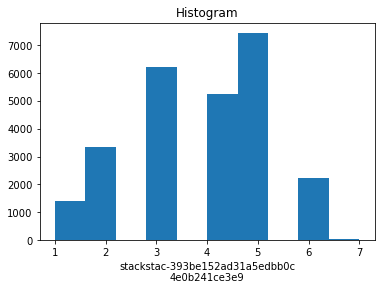

In [7]:
stack.plot()

In [8]:
def median(array, dim, keep_attrs=False, skipna=True, **kwargs):
    """ Runs a median on an dask-backed xarray.
    
    This function does not scale!
    It will rechunk along the given dimension, so make sure 
    your other chunk sizes are small enough that it 
    will fit into memory.
    
    :param DataArray array: An xarray.DataArray wrapping a dask array
    :param dim str: The name of the dim in array to calculate the median
    """
    if type(array) is xr.Dataset:
        return array.apply(median, dim=dim, keep_attrs=keep_attrs, **kwargs)
    
    if not hasattr(array.data, 'dask'):
        return array.median(dim, keep_attrs=keep_attrs, **kwargs)
    
    array = array.chunk({dim:-1})
    axis = array.dims.index(dim)
    median_func = np.nanmedian if skipna else np.median
    blocks = dask.array.map_blocks(median_func, array.data, dtype=array.dtype, drop_axis=axis, axis=axis, **kwargs)
    
    new_coords={k: v for k, v in array.coords.items() if k != dim and dim not in v.dims}
    new_dims = tuple(d for d in array.dims if d != dim)
    new_attrs = array.attrs if keep_attrs else None
    
    return xr.DataArray(blocks, coords=new_coords, dims=new_dims, attrs=new_attrs)

median_stack = median(stack, dim="time")

In [17]:
print(stack.nbytes)


974400


C:\Users\rscott\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


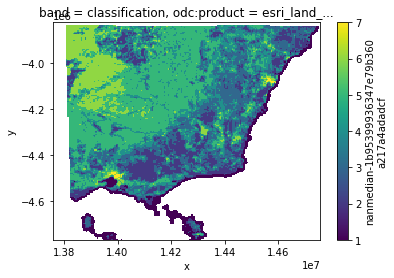

In [9]:
median_stack.plot()

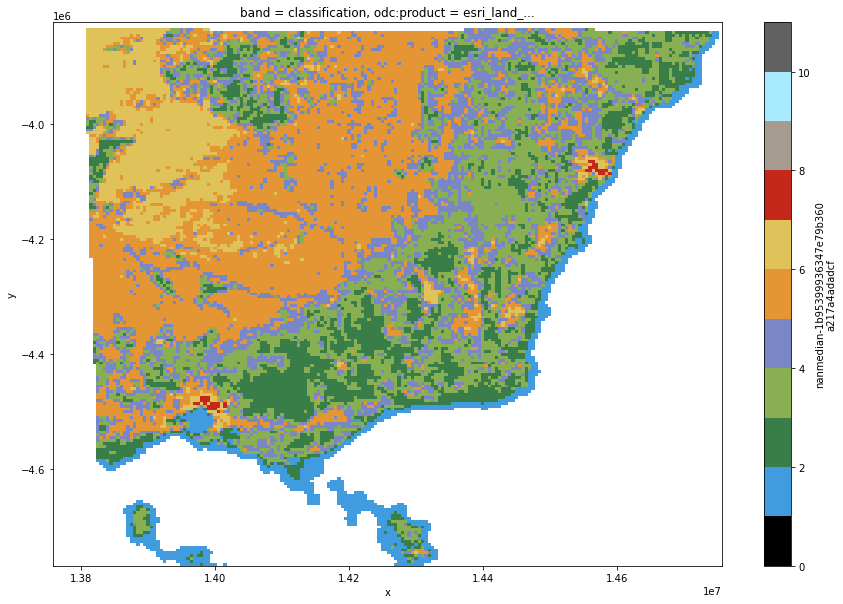

In [12]:
from matplotlib import colors as mcolours

cmap = mcolours.ListedColormap([
      np.array([0, 0, 0]) / 255,
      np.array([65, 155, 223]) / 255,
      np.array([57, 125, 73]) / 255,
      np.array([136, 176, 83]) / 255,
      np.array([122, 135, 198]) / 255,
      np.array([228, 150, 53]) / 255,
      np.array([223, 195, 90]) / 255,
      np.array([196 ,40, 27]) / 255,
      np.array([165, 155, 143]) / 255,
      np.array([168, 235, 255]) / 255,
      np.array([97, 97, 97]) / 255
])
bounds=range(0,12)
norm = mcolours.BoundaryNorm(np.array(bounds), cmap.N)


#stack.plot(aspect=1,size=8)

#stack.isel(time=0).squeeze().plot.imshow(cmap=cmap, norm=norm, size=10)

#stack.squeeze().plot.imshow(cmap=cmap, norm=norm, size=10)

median_stack.plot(cmap=cmap, norm=norm, size=10)


In [18]:
#brazil example
stack
#median_stack = median(stack, dim="time")

<xarray.DataArray 'stackstac-4383434de4f8b45456984e757e2e66b0' (time: 2, band: 1, y: 435, x: 140)>
dask.array<fetch_raster_window, shape=(2, 1, 435, 140), dtype=float64, chunksize=(1, 1, 435, 140), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time                  (time) datetime64[ns] 2020-01-01 2020-01-01
    id                    (time) <U36 'c80e9ea1-761c-5ce7-bb50-de93833cb87b' ...
  * band                  (band) <U14 'classification'
  * x                     (x) float64 -5.25e+06 -5.245e+06 ... -4.555e+06
  * y                     (y) float64 1.15e+05 1.1e+05 ... -2.05e+06 -2.055e+06
    title                 (time) <U25 '22M_20200101-20210101.tif' '22L_202001...
    ...                    ...
    cubedash:region_code  (time) <U3 '22M' '22L'
    proj:epsg             int32 32722
    created               <U20 '2020-01-01T00:00:00Z'
    odc:file_format       <U7 'GeoTIFF'
    odc:region_code       (time) <U3 '22M' '22L'
    epsg                  int32 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-5250000, -2060000, -4550000, ...
    crs:         epsg:6933
    transform:   | 5000.00, 0.00,-5250000.00|\n| 0.00,-5000.00, 115000.00|\n|...
    resolution:  5000

In [19]:
median_stack = median(stack, dim="time")

C:\Users\rscott\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


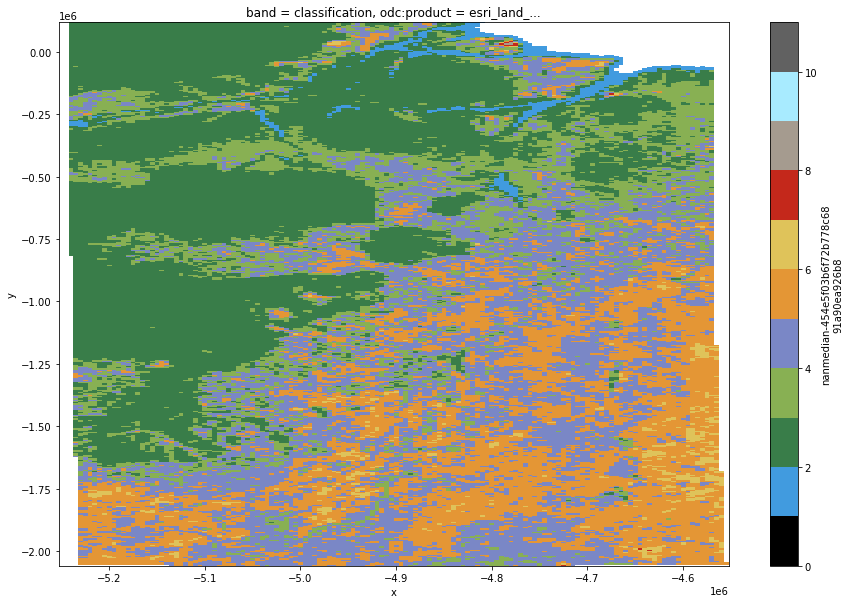

In [20]:
median_stack.plot(cmap=cmap, norm=norm, size=10)

In [42]:
median_stack = median_stack.astype('uint8')

In [43]:
median_stack

<xarray.DataArray 'nanmedian-454e5f03b6f72b778c6891a90ea926b8' (band: 1, y: 435, x: 140)>
dask.array<astype, shape=(1, 435, 140), dtype=uint8, chunksize=(1, 435, 140), chunktype=numpy.ndarray>
Coordinates:
  * band             (band) <U14 'classification'
  * x                (x) float64 -5.25e+06 -5.245e+06 ... -4.56e+06 -4.555e+06
  * y                (y) float64 1.15e+05 1.1e+05 ... -2.05e+06 -2.055e+06
    odc:product      <U15 'esri_land_cover'
    proj:epsg        int32 32722
    created          <U20 '2020-01-01T00:00:00Z'
    odc:file_format  <U7 'GeoTIFF'
    epsg             int32 6933

In [27]:
median_stack.rio.write_crs('epsg:32722')
median_stack.rio.to_raster('H:\Carajas-Grav-ESRI-LandCover.tif')

C:\Users\rscott\AppData\Roaming\Python\Python38\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [ ]:
cropped_median = median(cropped, dim="time")


In [44]:
cropped_median = cropped_median.astype('uint8')
cropped_median

,Array,Chunk
Bytes,1.32 GiB,1.00 MiB
Shape,"(1, 41196, 34282)","(1, 1024, 1024)"
Count,138359 Tasks,1435 Chunks
Type,uint8,numpy.ndarray


In [41]:

with dask.diagnostics.ProgressBar():
    cropped_median.rio.write_crs('epsg:6933')
    cropped_median.rio.to_raster('H:\Carajas-Grav-ESRI-LandCover-uint8.tif')

[########################################] | 100% Completed |  3min 43.0s


In [45]:
monthly = cropped.resample(time="MS").median("time", keep_attrs=True)
monthly

NotImplementedError: median is not yet implemented on dask arrays

In [46]:
cropped

,Array,Chunk
Bytes,2.63 GiB,1.00 MiB
Shape,"(2, 1, 41196, 34282)","(1, 1, 1024, 1024)"
Count,135489 Tasks,2870 Chunks
Type,uint8,numpy.ndarray


In [49]:
croppedGB = cropped.groupby("time")

In [50]:
croppedGB

DataArrayGroupBy, grouped over 'time'
1 groups with labels 2020-01-01.

In [53]:
for i in croppedGB:
    print(i)
    

(numpy.datetime64('2020-01-01T00:00:00.000000000'), <xarray.DataArray 'stackstac-ce7dde79f7841e596225ac766467cf4c' (time: 2, band: 1, y: 41196, x: 34282)>
dask.array<astype, shape=(2, 1, 41196, 34282), dtype=uint8, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * y                     (y) float64 -6.203e+05 -6.203e+05 ... -1.032e+06
  * x                     (x) float64 -5.116e+06 -5.116e+06 ... -4.773e+06
  * time                  (time) datetime64[ns] 2020-01-01 2020-01-01
    id                    (time) <U36 'c80e9ea1-761c-5ce7-bb50-de93833cb87b' ...
  * band                  (band) <U14 'classification'
    title                 (time) <U25 '22M_20200101-20210101.tif' '22L_202001...
    ...                    ...
    proj:epsg             int32 32722
    created               <U20 '2020-01-01T00:00:00Z'
    odc:file_format       <U7 'GeoTIFF'
    odc:region_code       (time) <U3 '22M' '22L'
    epsg                  int32 6933
    spatial_ref        

In [55]:
croppedMR = xr.merge(cropped, compat='override')

In [56]:
croppedMR

,Array,Chunk
Bytes,1.32 GiB,1.00 MiB
Shape,"(1, 41196, 34282)","(1, 1024, 1024)"
Count,136924 Tasks,1435 Chunks
Type,uint8,numpy.ndarray


In [57]:
croppedMR.nbytes

1412885608

In [58]:
croppedMR

AttributeError: 'Dataset' object has no attribute 'dtype'

In [ ]:
with dask.diagnostics.ProgressBar():
    cropped_median.rio.write_crs('epsg:6933')
    cropped_median.rio.to_raster('H:\Carajas-Grav-ESRI-LandCover-uint8-MR.tif')